In [1]:
from fastai.vision.all import *

# Imagenette

Small subset of imagenet, containing 10 'very different' categories'.

In [2]:
path = untar_data(URLs.IMAGENETTE)

In [3]:
files = list(get_image_files(path))

In [4]:
file = files[0]
file.parent.name

'n03028079'

In [5]:
df = pd.DataFrame(files, columns=['filename'])
df['target'] = df['filename'].apply(lambda p: p.parent.name)
df['is_valid'] = df['filename'].apply(lambda p: 'val' in str(p.parent))
df.head()

,filename,target,is_valid
0,/storage/data/imagenette2/val/n03028079/ILSVRC2012_val_00034021.JPEG,n03028079,True
1,/storage/data/imagenette2/val/n03028079/n03028079_31602.JPEG,n03028079,True
2,/storage/data/imagenette2/val/n03028079/n03028079_2782.JPEG,n03028079,True
3,/storage/data/imagenette2/val/n03028079/n03028079_50060.JPEG,n03028079,True
4,/storage/data/imagenette2/val/n03028079/n03028079_13981.JPEG,n03028079,True


In [6]:
small_df = df.sample(len(df)//4)

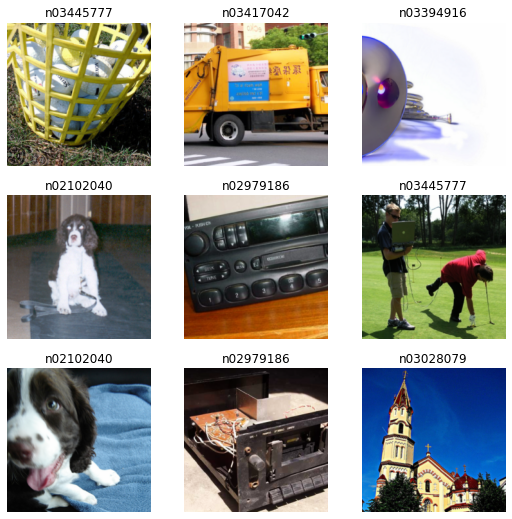

In [7]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_x=ColReader(0),
                   get_y=ColReader(1),
                   splitter=ColSplitter(),
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75),
                  )
dls = dblock.dataloaders(small_df, bs=32)
dls.show_batch()

In [8]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.442556,3.354861,0.257681,00:30
1,1.894590,1.557904,0.491576,00:27
2,1.574068,1.658698,0.462834,00:27
3,1.324305,1.224889,0.602577,00:27
4,1.158208,1.104974,0.643211,00:27


# Normalization

Calculate the mean/std for everything except the channel dimension. This gives the mean/std for each color channel:

In [9]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([0.4899, 0.4934, 0.4774], device='cuda:0'),
 TensorImage([0.2777, 0.2702, 0.2879], device='cuda:0'))

In [10]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_x=ColReader(0),
                   get_y=ColReader(1),
                   splitter=ColSplitter(),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=.75),
                              Normalize.from_stats(*imagenet_stats)]
                  )
    return dblock.dataloaders(small_df, bs=bs)

In [11]:
dls = get_dls(64, 224)
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([-0.0343,  0.1102,  0.2924], device='cuda:0'),
 TensorImage([1.2093, 1.2281, 1.3275], device='cuda:0'))

In [12]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.913410,3.915525,0.224975,00:30
1,2.246032,2.440460,0.352825,00:27
2,1.837322,1.616339,0.499504,00:27
3,1.550099,1.357338,0.577800,00:27
4,1.346053,1.223319,0.608523,00:27


# Progressive Resizing

In [13]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.449959,3.454950,0.217047,00:16
1,2.413091,2.878757,0.345887,00:13
2,1.918263,1.537930,0.504460,00:13
3,1.606836,1.246571,0.617443,00:14


In [14]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.230397,1.845466,0.443013,00:27


epoch,train_loss,valid_loss,accuracy,time
0,1.098881,1.316050,0.590684,00:28
1,1.074433,1.159064,0.648166,00:27
2,1.027508,1.062900,0.680872,00:27
3,0.959147,0.989220,0.684836,00:27
4,0.875593,0.954112,0.714569,00:28


# TTA

In [15]:
# setting the epoch to 0 seems to be a necessary as a bug-workaround
learn.epoch = 0
preds, targets = learn.tta()
accuracy(preds, targets).item()

0.7135778069496155

# MixUp

Use interpolation for both the inputs and targets:

$$ inp = \alpha*\text{input}_1 + (1-\alpha)*\text{input}_2 $$
$$ target = \alpha*\text{target}_1 + (1-\alpha)*\text{target}_2 $$

Usually it takes more epochs of training to see a positive (or even a non-negative) effect for mixup. The positive effect is expected to be better model generalization, so less overfitting.

In [20]:
from fastai.callback.mixup import MixUp

In [22]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.125620,3.314658,0.168484,00:13
1,2.901896,3.358825,0.243806,00:13
2,2.461859,2.766936,0.308226,00:13
3,2.173243,1.978962,0.421209,00:13
4,1.990098,1.928249,0.422200,00:13
5,1.830746,1.424163,0.552032,00:13
6,1.706335,1.262795,0.593657,00:13
7,1.591859,1.124954,0.640238,00:14
8,1.501562,1.004687,0.694747,00:13
9,1.430886,0.987097,0.688801,00:13


# Label Smoothing

Classically labeled categorical datasets have labels that are exactly 0 or 1. Since the commonly used activation functions use some sort of sigmoid, those values are in practice not actually achievable. Hence the idea to change those labels by an $\epsilon$:

$$ 0\longrightarrow \frac{\epsilon}{N} $$
$$ 1\longrightarrow 1-\frac{\epsilon}{N} $$

Again, this is only expected to produce better results when training for more epochs.

In [24]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.394353,3.268526,0.279485,00:14
1,3.538451,6.280836,0.203171,00:13
2,3.048189,2.958891,0.372646,00:13
3,2.751302,2.633081,0.465808,00:13
4,2.537727,2.529924,0.529237,00:13
5,2.363247,2.441460,0.572844,00:13
6,2.221633,1.986237,0.673935,00:13
7,2.090919,1.987904,0.667988,00:14
8,1.978175,1.889973,0.703667,00:14
9,1.888487,1.866532,0.715560,00:13
